### Informacje dotyczące pomiarów:

* Pomiary czasu dla funkcji odwracania uwzględniają czasy działania algorytmu mnożenia macierzy (tutaj Binet)
* Pomiary czasu dla funckji eliminacji Gaussowskiej uwzględniają czasy działania algorytmów odwracania macierzy i mnożenia macierzy
* W ramach zliczania operacji zmiennoprzecnikowych zliczano operacje na macierzach
* Pliki .csv zawierające pomiary egzekucji algorytmów na maszynie z procesorem i5 13-400f będą nazywane <nazwa_algorytmu>_results_i5_13400f.csv

### Przygotowanie importów do przetworzenia wyników:

Poniższą komórkę wystarczy uruchomić jeden raz.

In [ ]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("LaTeXStrings")
Pkg.add("StatsPlots");

To z kolei proszę uruchomić każdorazowo przed egzekucją kodu niżej w pliku.

In [64]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using LaTeXStrings
using StatsPlots;

##### Zakres generowania liczb losowych:

In [2]:
low = 0.00000001
high = 1.0;

##### Algorytm do porównywania identyczności macierzy:

In [3]:
error_eps = 1e-8

function are_equal(A,B)
    if !all(size(A) .== size(B))
        return false
    end
    return all(abs.(A-B) .< error_eps)
end;

##### Algorytm do generowania macierzy o losowych elementach:

In [4]:
function generate_random_matrix(m,n,a,b)
    A = zeros(m,n)
    for i in 1:m 
        for j in 1:n
            A[i,j] = a + (b-a)*rand()
        end
    end
    return A
end;

Implementacja funkcji Binet'a (pisana w ramch poprzedniego laboratorium), która posłuży do rekurencyjnego mnożenia macierzy.

Zdecydowano się na użycie tej funkcji ze względu na fakt, że jej wydajność czasowa nie ulega znacznym pogorszeniom przy zwiększaniu krawędzi macierzy z wartości $2^n$ do $2^{n+1}$, gdzie $n$ to dowolna liczba naturalna, oraz fakt, że Binet'em można w miarę prosty sposób mnożyć macierze, które się kwadratowe i różnią się dokładnymi kształtami.

In [5]:
function binet(A,B)
    if size(A)[2] != size(B)[1]
        return [[], 0, 0]  
    end    
    overall_number_of_additions = 0
    overall_number_of_multiplications = 0

    function internal_binet(A_,B_)
        m = size(A_)[1]
        n = size(A_)[2]
        p = size(B_)[2]
        if m == 1 && n == 1 && p == 1
            return reshape([A_[1,1]*B_[1,1]],1,1)
        elseif m > 1 && n > 1 && p > 1
            floor_m = div(m,2)
            floor_n = div(n,2)
            floor_p = div(p,2)
            A_11 = A_[1:floor_m , 1:floor_n]
            A_12 = A_[1:floor_m , floor_n+1:end]
            A_21 = A_[floor_m+1:end , 1:floor_n]        
            A_22 = A_[floor_m+1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:floor_p]
            B_12 = B_[1:floor_n , floor_p+1:end]
            B_21 = B_[floor_n+1:end , 1:floor_p]
            B_22 = B_[floor_n+1:end , floor_p+1:end]
            upper = [internal_binet(A_11,B_11)+internal_binet(A_12,B_21) internal_binet(A_11,B_12)+internal_binet(A_12,B_22)]
            lower = [internal_binet(A_21,B_11)+internal_binet(A_22,B_21) internal_binet(A_21,B_12)+internal_binet(A_22,B_22)]
            overall_number_of_additions += 4
            overall_number_of_multiplications += 8
            return [upper ; lower]
        elseif m == 1 && n > 1 && p > 1
            floor_n = div(n,2)
            floor_p = div(p,2)
            A_11 = A_[1:end , 1:floor_n]
            A_12 = A_[1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:floor_p]
            B_12 = B_[1:floor_n , floor_p+1:end]
            B_21 = B_[floor_n+1:end , 1:floor_p]
            B_22 = B_[floor_n+1:end , floor_p+1:end]
            overall_number_of_additions += 2
            overall_number_of_multiplications += 4
            return [internal_binet(A_11,B_11)+internal_binet(A_12,B_21) internal_binet(A_11,B_12)+internal_binet(A_12,B_22)]
        elseif m == 1 && n == 1 && p > 1
            floor_p = div(p,2)
            B_11 = B_[1:end , 1:floor_p]
            B_12 = B_[1:end , floor_p+1:end]
            overall_number_of_multiplications += 2
            return [internal_binet(A_,B_11) internal_binet(A_,B_12)]
        elseif m == 1 && n > 1 && p == 1
            floor_n = div(n,2)
            A_11 = A_[1:end , 1:floor_n]
            A_12 = A_[1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:end]
            B_21 = B_[floor_n+1:end , 1:end]
            overall_number_of_additions += 1
            overall_number_of_multiplications += 2
            return internal_binet(A_11,B_11)+internal_binet(A_12,B_21)
        elseif m > 1 && n == 1 && p > 1
            floor_m = div(m,2)
            floor_p = div(p,2)
            A_11 = A_[1:floor_m , 1:end]
            A_21 = A_[floor_m+1:end , 1:end]
            B_11 = B_[1:end , 1:floor_p ]
            B_12 = B_[1:end , floor_p+1:end]    
            overall_number_of_multiplications += 4
            upper = [internal_binet(A_11,B_11) internal_binet(A_11,B_12)]
            lower = [internal_binet(A_21,B_11) internal_binet(A_21,B_12)]
            return [upper ; lower]
        elseif m > 1 && n == 1 && p == 1   
            floor_m = div(m,2)
            A_11 = A_[1:floor_m , 1:end]
            A_21 = A_[floor_m+1:end , 1:end]
            overall_number_of_multiplications += 2
            return [internal_binet(A_11,B_) ; internal_binet(A_21,B_)] 
        elseif m > 1 && n > 1 && p == 1
            floor_m = div(m,2)
            floor_n = div(n,2)
            A_11 = A_[1:floor_m , 1:floor_n]
            A_12 = A_[1:floor_m , floor_n+1:end]
            A_21 = A_[floor_m+1:end , 1:floor_n]        
            A_22 = A_[floor_m+1:end , floor_n+1:end]
            B_11 = B_[1:floor_n , 1:end]
            B_21 = B_[floor_n+1:end , 1:end]
            overall_number_of_additions += 2
            overall_number_of_multiplications += 4
            return [internal_binet(A_11,B_11)+internal_binet(A_12,B_21) ; internal_binet(A_21,B_11)+internal_binet(A_22,B_21)]    
        end
    end

    return [internal_binet(A,B), overall_number_of_additions, overall_number_of_multiplications]

end;

### Rekurencyjny algorytm odwracania macierzy:

Wzór na rekurencyjnę odwracania macierzy można zapisać następująco:

$$ A^{-1} = \begin{bmatrix} B_{11} & B_{12} \\ B_{21} & B_{22} \end{bmatrix} $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

oraz:

$$ \text{1: } S_{22} = A_{22} - A_{21} A_{11}^{-1} A_{12} $$
$$ \text{2: } B_{11} = A_{11}^{-1} (I + A_{12} S_{22}^{-1} A_{21} A_{11}^{-1}) $$
$$ \text{3: } B_{12} = -A_{11}^{-1} A_{12} S_{22}^{-1} $$
$$ \text{4: } B_{21} = -S_{22}^{-1} A_{21} A_{11}^{-1} $$
$$ \text{5: } B_{22} = S_{22}^{-1} $$

gdzie $ I $ jest (kwadratową) macierzą identyczności (1 na głównej przekątnej, reszta 0).

Należy zaznaczyć, że podział macierzy A na podmacierze ma pewne ograniczenia wynikające ze wzorów 1-4 i definicji odwracalności macierzy. Mając na uwadzę te ograniczenia należy pokazać jaki podział na podmacierze jest dozwolony. 

Nawias (x,y) w dolnym indeksie oznacza, że macierz ma x wierszy i y kolumn.

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

W poniższych przekształceniach używano własności już udowodnionych w linjkach wyżej bez explicite pisania tego za każdym razem.

Z definicji odwracalności macierzy $ A_{11} $: $ \text{ } b = c $

Ze wzoru 1: $ \text{ } A_{21 (f,g)} A_{11 (b,b)}^{-1} A_{12 (d,e)} \text{ jest wykonywalne } (=\Omega _{(f,e)}) \text{ } \implies g = b \land b = d $ 

Ze wzoru 1 i powyższego: $ \text{ } A_{22 (h,i)} - \Omega _ {(f,e)} \text { jest wykonywalne } \implies h = f \land i = e $

Z własności odwracalności macierzy $ S_{22 (f,e)} $ : $ \text{ } h = i \land f = e $ 

Ze wzoru 2: $ \text{ } B_{11} = A_{11 (b,b)}^{-1} (I_{(b,b)} + A_{12 (b,e)} S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1}) \implies B_{11} = B_{11 (b,b)} $

Ze wzoru 3: $ \text{ } B_{12} = -A_{11 (b,b)}^{-1} A_{12 (b,e)} S_{22 {e,e}}^{-1} \implies B_{12} = B_{12 (b,e)} $

Ze wzoru 4: $ \text{ } B_{21} = -S_{22 (e,e)}^{-1} A_{21 (e,b)} A_{11 (b,b)}^{-1} \implies B_{21} = B_{21 (e,b)} $

Ze wzoru 5: $ \text{ } B_{22} = S_{22}^{-1} \implies B_{22} = B_{22 (e,e)} $

Powyższe wyprowadzanie pozwalają wysnuć wnioski na temat rozmiarów podmacierzy A, co jest bardzo ważne z punktu widzenia implementacji:

$$ A_{11} = A_{11 (b,b)} $$
$$ A_{12} = A_{12 (b,e)} $$
$$ A_{21} = A_{21 (e,b)} $$
$$ A_{22} = A_{22 (e,e)} $$

Biorąc pod uwagę, że $ b+e = n $ dla $ A_{(n,n)} $ przyjmujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod algorytmu rekurencyjnego odwracania macierzy:

In [16]:
function inverse(A, mult_method)
    if (size(A)[1] != size(A)[2])
        error("Something went wrong, can only invert square matrixes")
    end
    num_of_matrix_additions = 0
    num_of_matrix_multiplications = 0
    num_of_matrix_inversion = 0

    function internal_inverse(A_)
        n, m = size(A_)
        if (n != m) 
            error("Something went wrong, can only invert square matrixes")
        end
        if (n == 1)
            num_of_matrix_inversion += 1
            return reshape([A_[1,1]^(-1)],1,1)
        else
            b = div(n,2)
            A_11 = A_[1:b , 1:b]
            A_12 = A_[1:b , b+1:end]
            A_21 = A_[b+1:end , 1:b]
            A_22 = A_[b+1:end , b+1:end]

            A_11_inv = internal_inverse(A_11)
            F, add, mul = mult_method(A_21,A_11_inv)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            H, add, mul = mult_method(F,A_12)
            S_22 = A_22 - H
            num_of_matrix_additions += add+1
            num_of_matrix_multiplications += mul

            S_22_inv = internal_inverse(S_22)

            G, add, mul = mult_method(A_12,S_22_inv)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            J, add, mul = mult_method(G,F)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            B_11, add, mul = mult_method(A_11_inv,Matrix{Float64}(I,b,b)+J)
            num_of_matrix_additions += add+1
            num_of_matrix_multiplications += mul 

            K, add, mul = mult_method(A_11_inv,G)
            num_of_matrix_additions += add 
            num_of_matrix_multiplications += mul 
            B_12 = -K       

            L, add, mul = mult_method(S_22_inv,F)
            num_of_matrix_additions += add 
            num_of_matrix_multiplications += mul 
            B_21 = -L
            
            B_22 = S_22_inv

            num_of_matrix_inversion += 1

            return [B_11 B_12 ; B_21 B_22]  
        end
    end

    return internal_inverse(A), num_of_matrix_additions, num_of_matrix_multiplications, num_of_matrix_inversion

end;

Jeżli wyników testowania funkcji rekurencyjnej nie ma w pliku .csv, należy uruchomić poniższy kod:

In [86]:
function test_matrix_inversion(start_n, final_n, a, b, mult_method)
    working_properly = true
    log_matrix = zeros(final_n-start_n+1, 6)
    for n in start_n:1:final_n
        A = generate_random_matrix(n,n,a,b)
        exec_time = @elapsed results = inverse(A,mult_method)
        results_matrix, add, mul, invs = results
        correct_result = are_equal(results_matrix, inv(A))
        working_properly = working_properly && correct_result
        log_matrix[n-start_n+1, :] = [n, correct_result, add, mul, invs, exec_time] 
    end
    println(working_properly)
    return log_matrix
end;

In [16]:
start_n = 3
final_n = 300
filename = "inverse_results_i5_13400f.csv"
inv_df = DataFrame(test_matrix_inversion(start_n, final_n, low, high, binet), ["n", "correct", "additions", "multiplications", "inversions", "execution_time"]);

false


In [32]:
inv_df.n = Int.(inv_df.n)
inv_df.additions = Int.(inv_df.additions)
inv_df.multiplications = Int.(inv_df.multiplications)
inv_df.inversions = Int.(inv_df.inversions)
CSV.write(filename, inv_df);

Jeżeli wyniki są w pliku należy je wczytać przy użyciu poniższego kodu:

In [31]:
filename = "inverse_results_i5_13400f.csv"
inv_df = CSV.read(filename, DataFrame);

Wyświetl wyniki algorytmu:

In [33]:
inv_df

Row,n,correct,additions,multiplications,inversions,execution_time
,Int64,Float64,Int64,Int64,Int64,Float64
1,3,1.0,9,18,2,7.61e-5
2,4,1.0,34,56,3,6.39e-5
3,5,1.0,57,146,4,5.96e-5
4,6,1.0,111,274,5,7.21e-5
5,7,1.0,188,408,6,0.0001052
6,8,1.0,322,616,7,0.0001235
7,9,1.0,401,994,8,0.0001737
8,10,1.0,543,1482,9,0.0002366
9,11,1.0,713,1922,10,0.0003005


##### Wykres czasu egzekucji algorytmu:

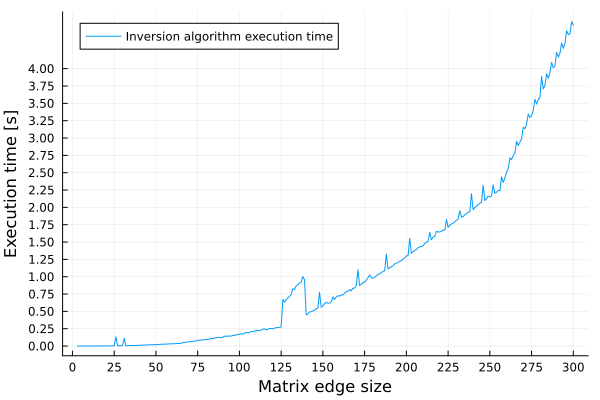

In [25]:
@df inv_df plot(:n, :execution_time, label="Inversion algorithm execution time", xlabel="Matrix edge size", ylabel="Execution time [s]", xticks=0:25:300, yticks=0:0.25:4)

In [27]:
savefig("inversion_exec_time_i5_13400f.png");

##### Wykres liczby operacji:

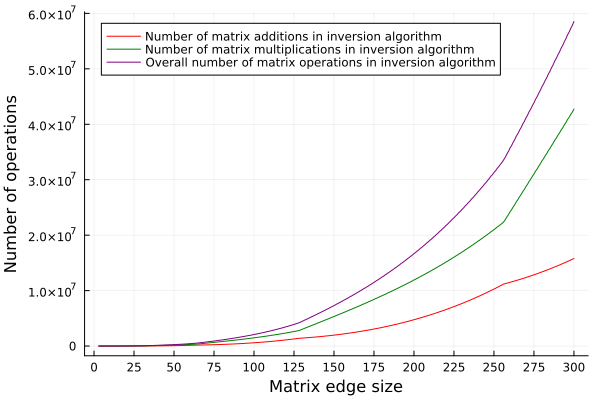

In [59]:
@df inv_df plot(:n, :additions, label="Number of matrix additions in inversion algorithm", xlabel="Matrix edge size", ylabel="Number of operations", color=:red, xticks=0:25:300)
@df inv_df plot!(:n, :multiplications, label="Number of matrix multiplications in inversion algorithm", color=:green)
@df inv_df plot!(:n, inv_df.additions+inv_df.multiplications, label="Overall number of matrix operations in inversion algorithm", color=:purple)

In [60]:
savefig("inversion_number_of_add_and_mul_i5_13400f.png");

### Rekurenycjny algorytm faktoryzacji LU:

Problem faktoryzacji LU jest często przedstawiany w następujący sposób:

$$ A = LU $$

gdzie:

$$ A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} $$

$$ L = \begin{bmatrix} L_{11} & 0 \\ L_{21} & L_{22} \end{bmatrix} $$

$$ U = \begin{bmatrix} U_{11} & U_{12} \\ 0 & U_{22} \end{bmatrix} $$

gdzie przez 0 w powyższych wzorach rozumiemy macierz wypełnioną 0.

Z uwagi na definicję faktoryzacji należy zaznaczyć, że macierz A musi być macierzą kwadratową, a zarówno L, jak i U muszą mieć takie same kształty co A.

Wprowadzamy również zapis funkcji faktoryzacji zwracającej macierze L oraz U:

$$ [L, U] = LU_{fact}(A) $$

Po wymnożeniu macierzy L i U otrzymujemy:

$$ LU = \begin{bmatrix} L_{11} U_{11} & L_{11} U_{12} \\ L_{21} U_{11} & L_{21} U_{12} + L_{22} U_{22} \end{bmatrix} $$

Przyrównajmy podmacierze z macierzy wynikowej do podmacierzy macierzy A:

$$ \text{I: } A_{11} = L_{11} U_{11} $$

$$ \text{II: } A_{12} = L_{11} U_{12} $$

$$ \text{III: } A_{21} = L_{21} U_{11} $$

$$ \text{IV: } A_{22} = L_{21} U_{12} + L_{22} U_{22} $$

Znalezienie podmacierzy L i U odbywa się następująco:

$$ \text{1: } [L_{11}, U_{11}] = LU_{fact}(A_{11}) $$

$$ \text{2: Mnożenie obustronne I przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{11} = L_{11}^{-1} L_{11} U_{11} \implies U_{11} = L_{11}^{-1} A_{11} $$

$$ \text{3: Mnożenie obustronne II przez } L_{11}^{-1} \text{ (lewostronne): } L_{11}^{-1} A_{12} = L_{11}^{-1} L_{11} U_{12} \implies U_{12} = L_{11}^{-1} A_{12} $$

$$ \text{4: Mnożenie obustronne III przez } U_{11}^{-1} \text{ (prawostronne): } A_{21} U_{11}^{-1} = L_{21} U_{11} U_{11}^{-1} \implies L_{21} = A_{21} U_{11}^{-1} $$

$$ \text{5: Odjęcie obustrone } L_{21} U_{12} \text{ w IV: } L_{22} U_{22} = A_{22} - L_{21} U_{12} \implies L_{22} U_{22} = A_{22} - A_{21} U_{11}^{-1} L_{11}^{-1} A_{12} $$ 

$$ \text{6: } [L_{22}, U_{22}] = LU_{fact}(L_{22} U_{22}) $$

Mając na uwadze punkty I-IV, 1-6 oraz własności problemów faktoryzacji LU, jak i inwersji macierzy ustalamy jakie kształty powinny mieć podmacierze A, L oraz U:

Tymczasowo zapiszmy:

$$ A_{11} = A_{11 (b,c)} $$
$$ A_{12} = A_{12 (d,e)} $$
$$ A_{21} = A_{21 (f,g)} $$
$$ A_{22} = A_{22 (h,i)} $$

Ze wzoru 1 oraz własności faktoryzacji LU: $ A_{11 (b,c)} = A_{11 (b,b)} $

Ze wzoru 1 oraz własności faktoryzacji LU: $ L_{11} = L_{11 (b,b)} \land U_{11} = U_{11 (b,b)} $

Ze wzoru 3 oraz własności inwersji macierzy: $ U_{12} = L_{11 (b,b)}^{-1} A_{12 (d,e)} \implies d=b \land U_{12} = U_{12 (b,e)} $

Ze wzoru 4 oraz własności inwersji macierzy: $ L_{21} = A_{21 (f,g)} U_{11 (b,b)}^{-1} \implies g=b \land L_{21} = L_{21 (f,b)} $

Ze wzoru 5: $ A_{22 (h,i)} A_{21 (f,b)} U_{11 (b,b)}^{-1} L_{11 (b,b)}^{-1} A_{12 (b,e)} \implies h=f \land i=e $

Ze wzoru 5: $ L_{22} U_{22} = (L_{22} U_{22})_{(f,e)} $

Ze wzoru 6 i własności faktoryzacji LU: $ L_{22} = L_{22 (f,e)} \land U_{22} = U_{22 (f,e)} \land f=e $

Podsumowując powyższe wyprowadzenia:

$$ b=c=d=g \land e=f=h=i $$

Wiedząc już jak należy podzielić macierz A przy wykonywaniu na niej faktoryzacji LU można już przystąpić do implementacji. Dokładne wartości $ b $ oraz $ e $ mogą być dowolne, o ile $ b+e=n $ (gdzie $ n $ to rozmiar krawędzi macierzy), przy implementacji (podobnie jak w przypadku odwracania macierzy) przymujemy, że $ b = \lfloor \frac{n}{2} \rfloor $ oraz $ e = n-b $.

##### Kod faktoryzacji LU:

In [35]:
function LU_fact(A, mult_method)
    if size(A)[1] != size(A)[2]
        error("Something went wrong, can only LU factorize square matrixes")
    end

    num_of_matrix_additions = 0
    num_of_matrix_multiplications = 0
    num_of_matrix_inversions = 0
    num_of_lu_facts = 0
    
    function internal_LU_fact(A_)
        m = size(A_)[1]
        n = size(A_)[2]
        if (m != n)
            error("Something went wrong, can only LU factorize square matrixes")
        end
        if n == 1
            return A_, reshape([1],1,1)
        else 
            b = div(n,2)
            A_11 = A_[1:b , 1:b]
            A_12 = A_[1:b , b+1:end]
            A_21 = A_[b+1:end , 1:b]
            A_22 = A_[b+1:end , b+1:end]
            
            L_11, U_11 = internal_LU_fact(A_11)
            num_of_lu_facts += 1

            L_11_inv, add, mul, invs = inverse(L_11,mult_method)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul
            num_of_matrix_inversions + invs

            U_11_inv, add, mul, invs = inverse(U_11,mult_method)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul 
            num_of_matrix_inversions += invs 

            L_21, add, mul = mult_method(A_21,U_11_inv)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul

            U_12, add, mul = mult_method(L_11_inv,A_12)
            num_of_matrix_additions += mul 
            num_of_matrix_multiplications += mul 

            P, add, mul = mult_method(L_21,U_12)
            num_of_matrix_additions += add
            num_of_matrix_multiplications += mul 

            S = A_22 - P 
            num_of_matrix_additions += 1

            L_22, U_22 = internal_LU_fact(S)
            num_of_lu_facts += 1

            return [L_11 zeros(b,n-b) ; L_21 L_22], [U_11 U_12 ; zeros(n-b,b) U_22]
        end
    end 

    result_L, result_U = internal_LU_fact(A)
    return result_L, result_U, num_of_matrix_additions, num_of_matrix_multiplications, num_of_matrix_inversions, num_of_lu_facts

end;

Jeżeli wyniki testowania algorytmu LU nie znajdując się w odpowiednim pliku .csv należy uruchomić poniższy kod:

In [38]:
function test_LU_fact(start_n, final_n, a, b, mult_method)
    log_matrix = zeros(final_n-start_n+1, 7)
    working_properly = true
    for n in start_n:1:final_n
        A = generate_random_matrix(n,n,a,b)
        execution_time = @elapsed results = LU_fact(A, mult_method)
        result_L, result_U, add, mul, invs, lufs = results
        correct_result = are_equal(result_L*result_U, A)
        working_properly = working_properly & correct_result
        log_matrix[n-start_n+1, :] = [n, correct_result, add, mul, invs, lufs, execution_time]
    end
    println(working_properly)
    return log_matrix
end;

In [39]:
start_n = 3
final_n = 300
filename = "lu_fact_results_i5_13400f.csv"
lu_df = DataFrame(test_LU_fact(start_n, final_n, low, high, binet), ["n","correct", "additions", "multiplications", "inversions", "lu_factorizations", "execution_time"]);

false


In [40]:
lu_df.n = Int.(lu_df.n)
lu_df.additions = Int.(lu_df.additions)
lu_df.multiplications = Int.(lu_df.multiplications)
lu_df.inversions = Int.(lu_df.inversions)
lu_df.lu_factorizations = Int.(lu_df.lu_factorizations)
CSV.write(filename, lu_df);

Jeżeli wyniki są już w pliku .csv wystarczy poniższe:

In [ ]:
filename = "lu_fact_results_i5_13400f.csv"
lu_df = CSV.read(filename, DataFrame)

Można wyświetlić wyniki:

In [41]:
lu_df

Row,n,correct,additions,multiplications,inversions,lu_factorizations,execution_time
,Int64,Float64,Int64,Int64,Int64,Int64,Float64
1,3,1.0,4,8,0,4,0.0001206
2,4,1.0,23,24,1,6,7.29e-5
3,5,1.0,34,64,1,8,6.91e-5
4,6,1.0,87,154,2,10,0.0001069
5,7,1.0,126,212,3,12,0.0001786
6,8,1.0,259,376,5,14,0.0002049
7,9,1.0,302,544,5,16,0.000215
8,10,1.0,475,930,6,18,0.000289
9,11,1.0,578,1158,7,20,0.0003444


##### Wykres czasu egzekucji algorytmu:

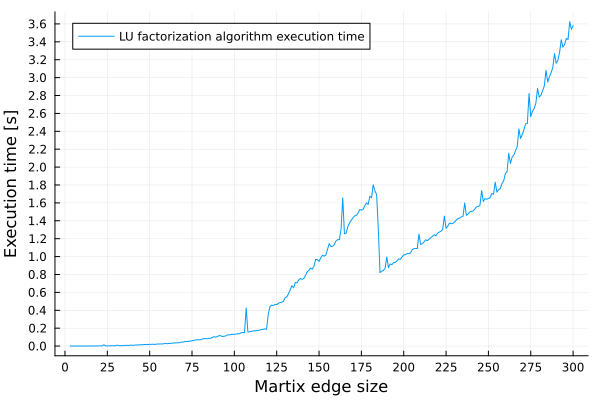

In [45]:
@df lu_df plot(:n, :execution_time, label="LU factorization algorithm execution time", xlabel="Martix edge size", ylabel="Execution time [s]", xticks=0:25:300, yticks=0:0.2:3.6)

In [47]:
savefig("LU_fact_execution_time_i5_13400f.png");

##### Wykres liczby operacji:

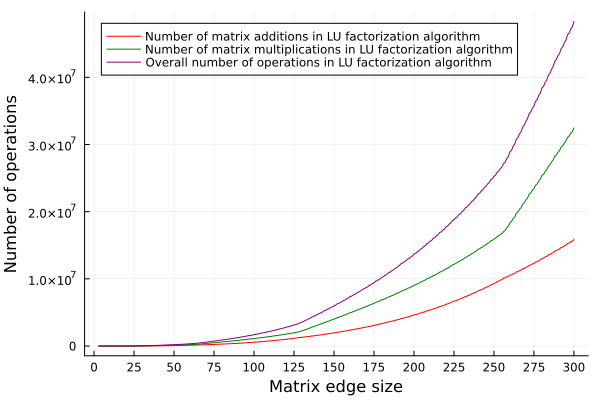

In [56]:
@df lu_df plot(:n, :additions, label="Number of matrix additions in LU factorization algorithm", xlabel="Matrix edge size", ylabel="Number of operations", xticks=0:25:300, color=:red)
@df lu_df plot!(:n, :multiplications, label="Number of matrix multiplications in LU factorization algorithm", color=:green)
@df lu_df plot!(:n, lu_df.additions+lu_df.multiplications, label="Overall number of operations in LU factorization algorithm", color=:purple)

In [57]:
savefig("LU_fact_number_of_matrix_ops_i5_13400f.png");

### Złożoność obliczeniowa algorytmów:

Bazując na wykresach czasu egzekucji algorytmów oraz liczb operacji, można dojść do wniosku, że złożoności algorytmów odwracania macierzy oraz faktoryzacji są w bardzo dużej mierze zależne od użytego algorytmu mnożenia macierzy. Użyty wyżej algorytm Binet'a ma złożność ~$ O(n^{3}) $, co dość dobrze widać na wykresach:

##### Dla algorytmu odwracania macierzy:

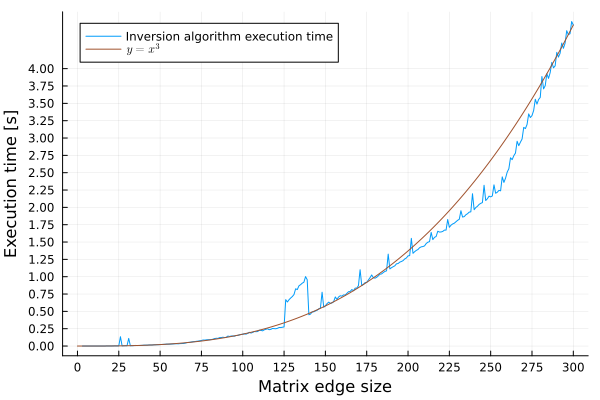

In [80]:
coef = inv_df[end, :execution_time] / (final_n^3)
@df inv_df plot(:n, :execution_time, label="Inversion algorithm execution time", xlabel="Matrix edge size", ylabel="Execution time [s]", xticks=0:25:300, yticks=0:0.25:4)
plot!(0:0.25:300, x->coef*(x^3), label=L"$y=x^{3}$", color=:sienna)

In [81]:
savefig("inversion_binet_time_complexity_comparison(exec_time)_i5_13400f.png");

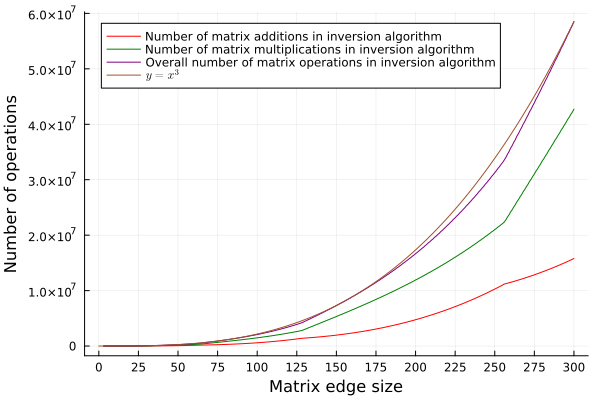

In [78]:
coef = (inv_df[end, :additions]+inv_df[end, :multiplications]) / (final_n^3)
@df inv_df plot(:n, :additions, label="Number of matrix additions in inversion algorithm", xlabel="Matrix edge size", ylabel="Number of operations", color=:red, xticks=0:25:300)
@df inv_df plot!(:n, :multiplications, label="Number of matrix multiplications in inversion algorithm", color=:green)
@df inv_df plot!(:n, inv_df.additions+inv_df.multiplications, label="Overall number of matrix operations in inversion algorithm", color=:purple)
plot!(0:0.25:300, x->coef*(x^3), label=L"$y=x^{3}$", color=:sienna)

In [79]:
savefig("inversion_binet_time_complexity_comparison(ops)_i5_13400f.png");

##### Dla algorytmu faktoryzacji LU:

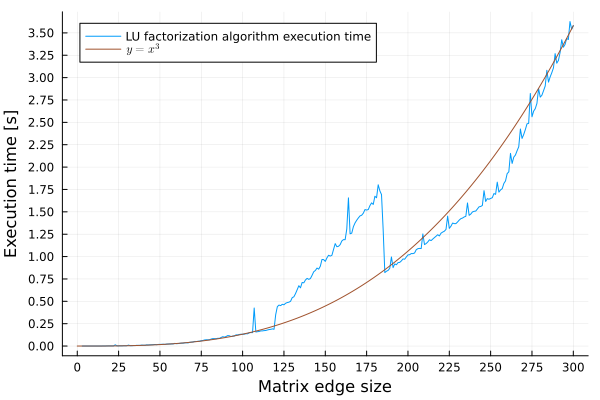

In [82]:
coef = lu_df[end, :execution_time] / (final_n^3)
@df lu_df plot(:n, :execution_time, label="LU factorization algorithm execution time", xlabel="Matrix edge size", ylabel="Execution time [s]", xticks=0:25:300, yticks=0:0.25:4)
plot!(0:0.25:300, x->coef*(x^3), label=L"$y=x^{3}$", color=:sienna)

In [84]:
savefig("LU_fact_binet_time_complexity_comparison(exec_time)_i5_13400f.png");

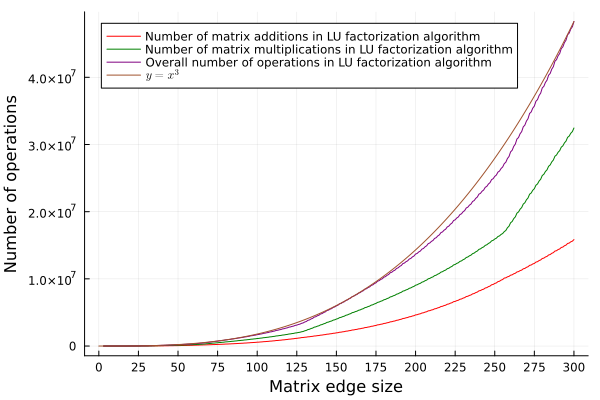

In [85]:
coef = (lu_df[end, :additions]+lu_df[end, :multiplications]) / (final_n^3)
@df lu_df plot(:n, :additions, label="Number of matrix additions in LU factorization algorithm", xlabel="Matrix edge size", ylabel="Number of operations", xticks=0:25:300, color=:red)
@df lu_df plot!(:n, :multiplications, label="Number of matrix multiplications in LU factorization algorithm", color=:green)
@df lu_df plot!(:n, lu_df.additions+lu_df.multiplications, label="Overall number of operations in LU factorization algorithm", color=:purple)
plot!(0:0.25:300, x->coef*(x^3), label=L"$y=x^{3}$", color=:sienna)

Aby być pewniejszym tezy przedstawionej na początku sekcji warto sprawdzić jak zmieni się złożność w przypadku użyciu algorytmu Strassen'a zamiast algorytmu Binet'a do mnożenia macierzy. Algorytm Strassen'a ma złożoność ~$O(7^{\lceil log_{2}n \rceil})$, więc odpowiednio powinny zmienić się czasy działań i liczby operacji na macierzach algorytmów.

In [123]:
function is_square(A)
    return size(A)[1] == size(A)[2]
end


function pad_with_zeros(A,p,r)
    m, n = size(A)
    return [A zeros(m,r-n) ; zeros(p-m,r)]
end


function strassen(A,B)
    if size(A)[2] != size(B)[1]
        return [], 0, 0
    end
    tm = size(A)[1]
    tp = size(B)[2]
    if !is_square(A) || !is_square(B)
        m, n = size(A)
        p = size(B)[2]
        pad_num = max(m,n,p)
        A = pad_with_zeros(A,pad_num,pad_num)
        B = pad_with_zeros(B,pad_num,pad_num)
    end  
    overall_number_of_additions = 0
    overall_number_of_multiplications = 0
    
    function internal_strassen(A_,B_)
        local n = size(A_)[1]
        if n == 1
            return [A_[1,1]*B_[1,1]]
        else
            n_divby_2 = div(n,2)
            if n%2 != 0
                A_ = [A_ zeros(n,1) ; zeros(1,n+1)]
                B_ = [B_ zeros(n,1) ; zeros(1,n+1)]
                n_divby_2 = div(n+1,2)
            end
            A_11 = A_[1:n_divby_2 , 1:n_divby_2]
            A_12 = A_[1:n_divby_2 , n_divby_2+1:end]
            A_21 = A_[n_divby_2+1:end , 1:n_divby_2]
            A_22 = A_[n_divby_2+1:end , n_divby_2+1:end]
            B_11 = B_[1:n_divby_2 , 1:n_divby_2]
            B_12 = B_[1:n_divby_2 , n_divby_2+1:end]
            B_21 = B_[n_divby_2+1:end , 1:n_divby_2]
            B_22 = B_[n_divby_2+1:end , n_divby_2+1:end]
            P_1 = internal_strassen((A_11+A_22),(B_11+B_22))
            P_2 = internal_strassen((A_21+A_22),B_11)
            P_3 = internal_strassen(A_11,(B_12-B_22))
            P_4 = internal_strassen(A_22,(B_21-B_11))
            P_5 = internal_strassen((A_11+A_12),B_22)
            P_6 = internal_strassen((A_21-A_11),(B_11+B_12))
            P_7 = internal_strassen((A_12-A_22),(B_21+B_22))
            overall_number_of_additions += 18
            overall_number_of_multiplications += 7
            return [P_1+P_4-P_5+P_7 P_3+P_5 ; P_2+P_4 P_1-P_2+P_3+P_6][1:n , 1:n]
        end
    end    

    return internal_strassen(A,B)[1:tm , 1:tp], overall_number_of_additions, overall_number_of_multiplications

end;

Jeżeli wyników nie ma w odpowiednim pliku .csv należy uruchomić poniższe:

In [ ]:
start_n = 3
final_n = 260
filename = "inverse_results_strassen_i5_13400f.png"
inv_df_s = DataFrame(test_matrix_inversion(start_n, final_n, low, high, strassen), ["n", "correct", "additions", "multiplications". "inversions", "execution_time"]);

In [ ]:
inv_df_s.additions = Int.(inv_df_s.additions)
inv_df_s.multiplications = Int.(inv_df_s.multiplications)
inv_df_s.inversions = Int.(inv_df_s.inversions)
CSV.write(filename, inv_df_s)

Jeżeli wyniki znajdują się w odpowiednim pliku można je wczytać bez wyliczania:

In [ ]:
filname = "inverse_results_strassen_i5_13400f.png"
inv_df_s = CSV.read(filename, DataFrame);

In [ ]:
inv_df_s

Sprawdźmy jak zmieniła się złożoność:

##### Dla algorytmu odwracania macierzy:

In [ ]:
coef = inv_df_s[end, :execution_time] / (7^ceil(log2(final_n)))
@df inv_df_s plot(:n, :execution_time, label="Inversion algorithm execution time", xlabel="Matrix edge size", ylabel="Execution time [s]", xticks=0:25:300, yticks=0:0.25:4)
plot!(0:0.25:300, x->coef*(7^ceil(log2(x))), label=L"$y=x^{3}$", color=:sienna)